# グラフ描画用

## import

In [16]:
import numpy as np
import scipy.linalg
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.colorbar as colorbars
import matplotlib.gridspec as gridspec
import datetime
import os
import time
import pathlib
import sys
import uncertainties
from uncertainties import ufloat

plt.rcParams["font.family"] = "Helvetica"
plt.rcParams['mathtext.fontset'] = 'cm'

## spectral gap 実験

### 定数

In [17]:
n_spin_min = 3
n_spin_max = 12
beta_list = [1e-1, 1e0, 2e0, 5e0, 1e1]

### データのロード

axis=0: 逆温度, axis=1: サイト数, axis=2: 提案, axis=3: インスタンス

In [18]:
n_spin_list = np.arange(n_spin_min, n_spin_max+1)

# データ取得
i = 0
for beta in beta_list:
	j = 0
	for n_spin in n_spin_list:
		if j == 0:
			gap_data_beta = np.load("../result/spectral_gap/{0}_sites/beta_{1}.npy".format(n_spin, '{:.0e}'.format(beta_list[i])))[np.newaxis]
		else:
			gap_data_beta = np.concatenate([gap_data_beta, np.load("../result/spectral_gap/{0}_sites/beta_{1}.npy".format(n_spin, '{:.0e}'.format(beta_list[i])))[np.newaxis]])
		j += 1

	if i == 0:
		gap_data = gap_data_beta[np.newaxis]
	else:
		gap_data = np.concatenate([gap_data, gap_data_beta[np.newaxis]])
 
	i += 1
 
# 形状確認
print(gap_data.shape)

(5, 10, 4, 100)


### 計算

In [19]:
mean_gap_data = np.average(gap_data, axis=3)
std_gap_data = np.std(gap_data, axis=3)

print(mean_gap_data.shape)
print(std_gap_data.shape)

# 近似曲線計算
def exp_func(x, a):
    return 2**(-a*x)

def exp_func_2(x, a, b):
    return 2**(-a * (x+b) )

def exp_fit(x_data, y_data, y_std):
    # maxfev：関数の呼び出しの最大数, check_finite：Trueの場合NaNが含まれている場合はValueError発生
    # sigma : y_dataの標準偏差を入れることで、uncertaintyを計算できる？
    l_popt, l_pcov = curve_fit(exp_func, x_data, y_data, sigma=y_std, maxfev=10000, check_finite=False)
    return exp_func(x_data, *l_popt), l_popt, l_pcov

def exp_fit_2(x_data, y_data, y_std):
    # maxfev：関数の呼び出しの最大数, check_finite：Trueの場合NaNが含まれている場合はValueError発生
    # sigma : y_dataの標準偏差を入れることで、uncertaintyを計算できる？
    l_popt, l_pcov = curve_fit(exp_func_2, x_data, y_data, sigma=y_std, maxfev=10000, check_finite=False)
    return exp_func_2(x_data, *l_popt), l_popt, l_pcov

(5, 10, 4)
(5, 10, 4)


### plot

(10,) (10,)
(10,) (10,)
(10,) (10,)
(10,) (10,)
(10,) (10,)


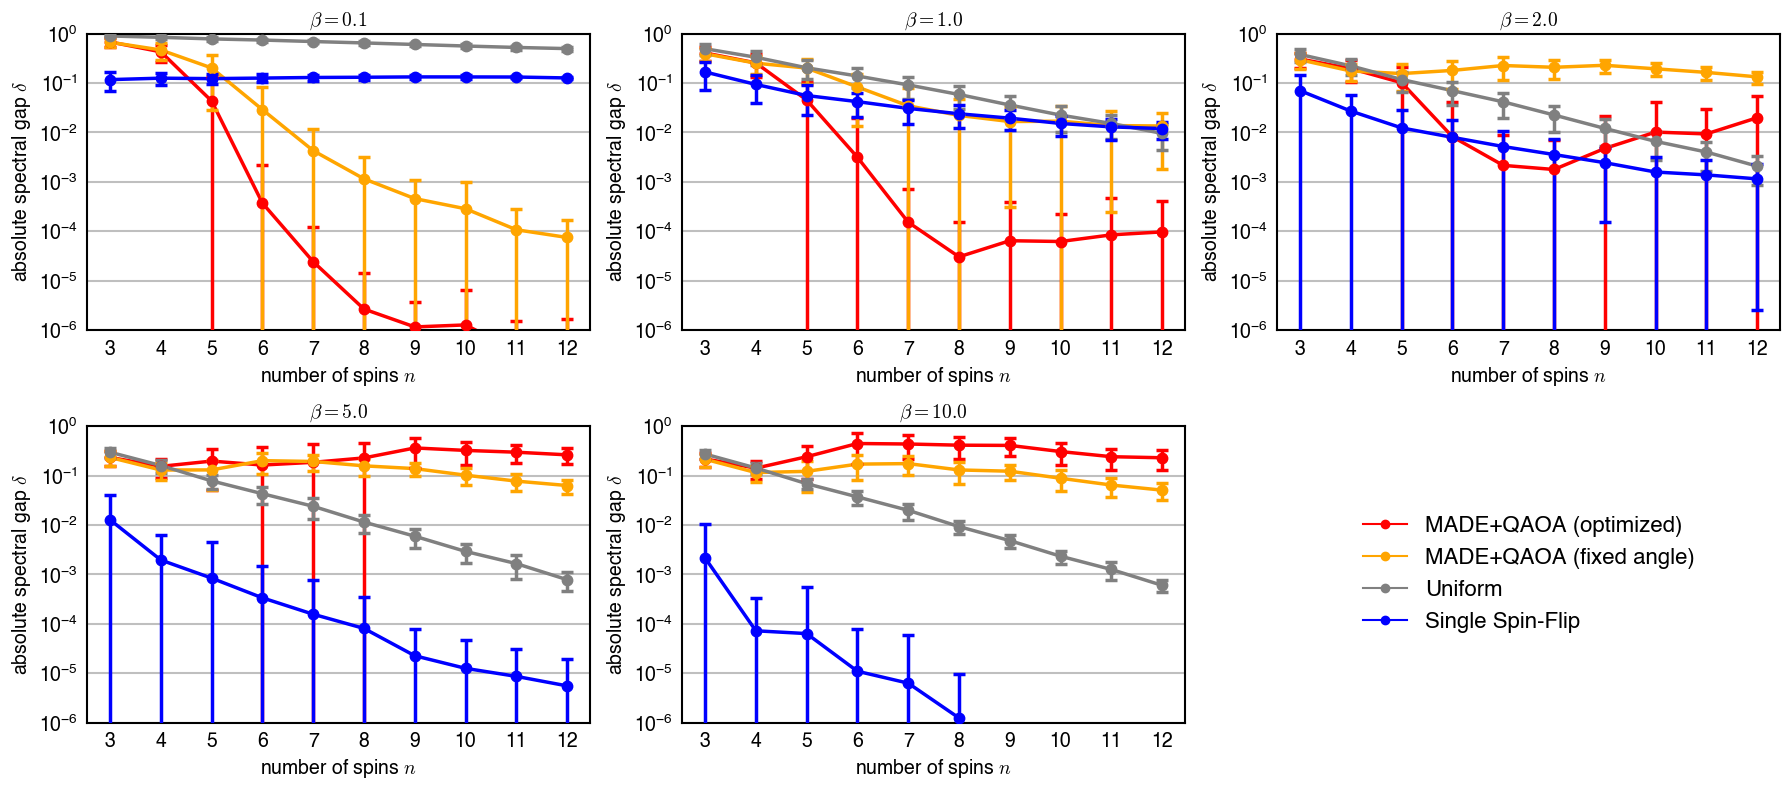

In [20]:
n_row = 2
n_col = 3

capsize = 4
markersize = 7.5
elinewidth = 2.5
capthick = 2.5
linewidth = 2.5

fig1, ax1 = plt.subplots(n_row, n_col, figsize=(18,8), dpi=100)

for i in range(len(beta_list)):
	row = i // n_col
	col = i % n_col
	
	print(n_spin_list.shape, mean_gap_data[i,:,0].shape)
	ax1[row,col].errorbar(n_spin_list, mean_gap_data[i,:,0], std_gap_data[i,:,0], color='red', linestyle='none', marker='o', markersize=markersize, capsize=capsize, capthick=capthick, elinewidth=elinewidth, label='MADE+QAOA (optimized)', zorder=4)
	ax1[row,col].errorbar(n_spin_list, mean_gap_data[i,:,1], std_gap_data[i,:,1], color='orange', linestyle='none', marker='o', markersize=markersize, capsize=capsize, capthick=capthick, elinewidth=elinewidth, label='MADE+QAOA (fixed angle)', zorder=4)
	ax1[row,col].errorbar(n_spin_list, mean_gap_data[i,:,2], std_gap_data[i,:,2], color='grey', linestyle='none', marker='o', markersize=markersize, capsize=capsize, capthick=capthick, elinewidth=elinewidth, label='Uniform,', zorder=4)
	ax1[row,col].errorbar(n_spin_list, mean_gap_data[i,:,3], std_gap_data[i,:,3], color='blue', linestyle='none', marker='o', markersize=markersize, capsize=capsize, capthick=capthick, elinewidth=elinewidth, label='Single Spin-Flip', zorder=4)
	ax1[row,col].set_xticks(n_spin_list)
 
	ax1[row,col].plot(n_spin_list, mean_gap_data[i,:,0], color='red', linewidth=linewidth)
	ax1[row,col].plot(n_spin_list, mean_gap_data[i,:,1], color='orange', linewidth=linewidth)
	ax1[row,col].plot(n_spin_list, mean_gap_data[i,:,2], color='grey', linewidth=linewidth)
	ax1[row,col].plot(n_spin_list, mean_gap_data[i,:,3], color='blue', linewidth=linewidth)
	ax1[row,col].grid(axis='y', color='#BFBFBF', linestyle='-', linewidth=1.5)
 
	ax1[row,col].set_axisbelow(True) #gridを背面にする

	spines = 1.5
	ax1[row,col].spines["top"].set_linewidth(spines)
	ax1[row,col].spines["left"].set_linewidth(spines)
	ax1[row,col].spines["bottom"].set_linewidth(spines)
	ax1[row,col].spines["right"].set_linewidth(spines)
	
	ax1[row,col].set_yscale("log")
	ax1[row,col].set_ylim(1e-6, 1e0)
	ax1[row,col].set_xlabel(r'number of spins $n$', fontsize=14)
	ax1[row,col].set_ylabel(r'absolute spectral gap $\delta$', fontsize=14)
	ax1[row,col].tick_params(width=0.0, labelsize=14)
	ax1[row,col].minorticks_off()
	ax1[row,col].set_title(r'$\beta={0}$'.format(beta_list[i]),{"fontsize": 14})

	#if i == len(beta_list)-1:
		#ax1[row,col].legend(fontsize=14, bbox_to_anchor=(1.2, 1.0))
  
ax1[-1,-1].plot([], [], marker='o', color='red', label='MADE+QAOA (optimized)', linestyle=None)
ax1[-1,-1].plot([], [], marker='o', color='orange', label='MADE+QAOA (fixed angle)', linestyle=None)
ax1[-1,-1].plot([], [], marker='o', color='grey', label='Uniform', linestyle=None)
ax1[-1,-1].plot([], [], marker='o', color='blue', label='Single Spin-Flip', linestyle=None)

for spine in ax1[-1,-1].spines.values():
    spine.set_visible(False)
ax1[-1,-1].axes.get_xaxis().set_visible(False)
ax1[-1,-1].axes.get_yaxis().set_visible(False)

ax1[-1,-1].legend(fontsize=16, bbox_to_anchor=(0.5,0.5), loc='center', frameon=False)

plt.tight_layout()
#fig1.savefig("ave_gap_vs_qubit.svg", dpi=300)
fig1.savefig("ave_gap_vs_qubit.png", dpi=300)